<a href="https://colab.research.google.com/github/ap0phasi/cerberusPy/blob/dev_s4layer/tests/example_cerberus_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modular CerberusTS Experimentation

First we make sure we are in the base working directory (this is probably not necessary if using the package):

Google Colab notebooks come with most of the packages we need, but we need to upgrade pandas and install accelerate.

Then we import the necessary CerberusTS modules.

In [1]:
!git clone --branch dev_s4layer https://github.com/ap0phasi/cerberusPy.git

fatal: destination path 'cerberusPy' already exists and is not an empty directory.


In [2]:
import os
os.chdir('cerberusPy')

In [3]:
!pip install pandas==2.0.3
!pip install accelerate

In [4]:
from cerberus_ts import Cerberus, train_cerberus
from cerberus_ts import Foresight, train_foresight
from cerberus_ts import TimeseriesDataPreparer, ResponseGenerator

import pandas as pd

Here we have the ability to do some custom configuration:

In [5]:
from cerberus_ts import CerberusConfig
CerberusConfig.set_masked_norm_zero = True

## Dataset Loading

Next we need a Pandas Dataframe of some wide-formatted mutlivariate timeseries data. Here we will use the Jena Climate Data found here: https://www.kaggle.com/datasets/mnassrib/jena-climate

In [6]:
df = pd.read_csv(r"data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'],
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
# For these tests we will just use a small slice of the dataset
df = df.iloc[:5000,:]

## User Argument Specification
There are a number of different arguments that can be provided to Cerberus, shown below:

In [7]:
# What ratio of data needs to be available for the various call, response, and context windows to use that timestamp?
thresholds = {
    'call': 1,
    'response': 1,
    'context_0': 1,
    'context_1': 1,
    'context_2': 1
}

# How big should the call, context(s), and response windows be?
sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

# What timestep should each head use?
window_timesteps = {
    'call': '10T',
    'response': '10T',
    'context_0': '1H',
    'context_1': '2H',
    'context_2': '6H'
}

# Which columns should be used for each head?
feature_indexes = {
    'call': range(0,14),
    'response': [0, 1, 4],
    'context_0': range(0,14),
    'context_1': range(0,14),
    'context_2': range(0,14)
}

## Prepare Dataset

We will use CerberusTS's TimeseriesDataPreparer class to create Torch dataloaders for all our different heads, scaled, downsampled, and coil-normalized for easy Cerberus use.

In [8]:
# Initialize the preparer
preparer = TimeseriesDataPreparer(df, sizes, thresholds, feature_indexes, window_timesteps, train_len = 20_000, feature_range = (0, 1), batch_size = 100)

# Prepare the data
preparer.prepare_data()

In [9]:
next(iter(preparer.dataloaders[0]))[0].device

device(type='cuda', index=0)

## Foresight Training

First, we can optionally train Foresight to aid CerberusTS:

In [10]:
foresight = Foresight(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=128,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [128, 128],
                 dropout_rate = 0.0,
                 eventualities = 10,
                 expander_sizes = [128, 256],
                 out_channels = 30,
                 kernel_size = 3)

In [11]:
foresight = train_foresight(foresight, preparer.dataloaders, num_epochs = 30)

Epoch [1/30], Loss: 0.014390542538215716
Epoch [2/30], Loss: 0.011174976006150245
Epoch [3/30], Loss: 0.009079441086699565
Epoch [4/30], Loss: 0.00816025363902251
Epoch [5/30], Loss: 0.007345582799365123
Epoch [6/30], Loss: 0.006630222915361325
Epoch [7/30], Loss: 0.006081790067255497
Epoch [8/30], Loss: 0.005484932331989209
Epoch [9/30], Loss: 0.004965822092878322
Epoch [10/30], Loss: 0.004415498840001722
Epoch [11/30], Loss: 0.0037936317982772984
Epoch [12/30], Loss: 0.0032455376349389553
Epoch [13/30], Loss: 0.0028045951303405066
Epoch [14/30], Loss: 0.0023539203180310627
Epoch [15/30], Loss: 0.0020114309169972935
Epoch [16/30], Loss: 0.001725222928604732
Epoch [17/30], Loss: 0.0015098337829113006
Epoch [18/30], Loss: 0.0012484302266966552
Epoch [19/30], Loss: 0.0011463244856956105
Epoch [20/30], Loss: 0.0010286574201503148
Epoch [21/30], Loss: 0.0009191269668129583
Epoch [22/30], Loss: 0.0008659608382731676
Epoch [23/30], Loss: 0.0008238349558087066
Epoch [24/30], Loss: 0.000733507

## CerberusTS Training (No Foresight)

In [12]:
cerberus_noforesight = Cerberus(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=128,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [128, 128, 128],
                 dropout_rate = 0.0,
                 out_channels = 30,
                 kernel_size = 3)


In [13]:
cerberus_noforesight = train_cerberus(cerberus_noforesight, preparer.dataloaders, num_epochs = 60)

Epoch [1/60], Loss: 0.00151464230613783
Epoch [2/60], Loss: 0.0009994832556306694
Epoch [3/60], Loss: 0.0009276000142563135
Epoch [4/60], Loss: 0.0008913910709088668
Epoch [5/60], Loss: 0.0008692173853827019
Epoch [6/60], Loss: 0.0008401231075792263
Epoch [7/60], Loss: 0.0008189662380997712
Epoch [8/60], Loss: 0.0008052171401989956
Epoch [9/60], Loss: 0.000786106667170922
Epoch [10/60], Loss: 0.0007745291769970208
Epoch [11/60], Loss: 0.0007564546916789065
Epoch [12/60], Loss: 0.0007414002409980943
Epoch [13/60], Loss: 0.0007111568052399282
Epoch [14/60], Loss: 0.0006943465092141802
Epoch [15/60], Loss: 0.0006724648134938131
Epoch [16/60], Loss: 0.0006514002823193247
Epoch [17/60], Loss: 0.0006371653902654846
Epoch [18/60], Loss: 0.0006274119440543776
Epoch [19/60], Loss: 0.0006029686197871342
Epoch [20/60], Loss: 0.0005882647292067607
Epoch [21/60], Loss: 0.0005775403838682299
Epoch [22/60], Loss: 0.0005714832700323314
Epoch [23/60], Loss: 0.0005532858658504362
Epoch [24/60], Loss: 0.

## CerberusTS Training (With Foresight)
With the Foresight model trained (and weights frozen), we can pass this into a Cerberus model and train the remaining weights to generate predictions.

In [17]:
cerberus_foresight = Cerberus(sizes=sizes,
                 feature_indexes=feature_indexes,
                 d_neck=128,
                 head_layers=["conv","conv"],
                 body_layer_sizes = [128, 128, 128],
                 dropout_rate = 0.0,
                 foresight = foresight,
                 eventualities = 10,
                 out_channels = 30,
                 kernel_size = 3)

In [18]:
cerberus_foresight = train_cerberus(cerberus_foresight, preparer.dataloaders, num_epochs = 60)

Epoch [1/60], Loss: 0.0012304036391045277
Epoch [2/60], Loss: 0.0008450911968247965
Epoch [3/60], Loss: 0.0007846557422696302
Epoch [4/60], Loss: 0.0007542795379413291
Epoch [5/60], Loss: 0.0007344075676519423
Epoch [6/60], Loss: 0.0007190133571081484
Epoch [7/60], Loss: 0.0006666920299176126
Epoch [8/60], Loss: 0.0006420583405997605
Epoch [9/60], Loss: 0.0006180319316141928
Epoch [10/60], Loss: 0.0005762432635917018
Epoch [11/60], Loss: 0.000555652721474568
Epoch [12/60], Loss: 0.0005350665246563343
Epoch [13/60], Loss: 0.0005043477836685876
Epoch [14/60], Loss: 0.00048395547453158845
Epoch [15/60], Loss: 0.00047147374745691193
Epoch [16/60], Loss: 0.00045605200158509737
Epoch [17/60], Loss: 0.000430876962976375
Epoch [18/60], Loss: 0.00040875545179005715
Epoch [19/60], Loss: 0.00039930331511034943
Epoch [20/60], Loss: 0.0003912645330031713
Epoch [21/60], Loss: 0.0003590896553942002
Epoch [22/60], Loss: 0.0003486594481122059
Epoch [23/60], Loss: 0.00034262828490075965
Epoch [24/60], L

## Results Review

CerberusTS has some built in functionality for generating responses as well as visualizing the results.

### Normalized Response Review

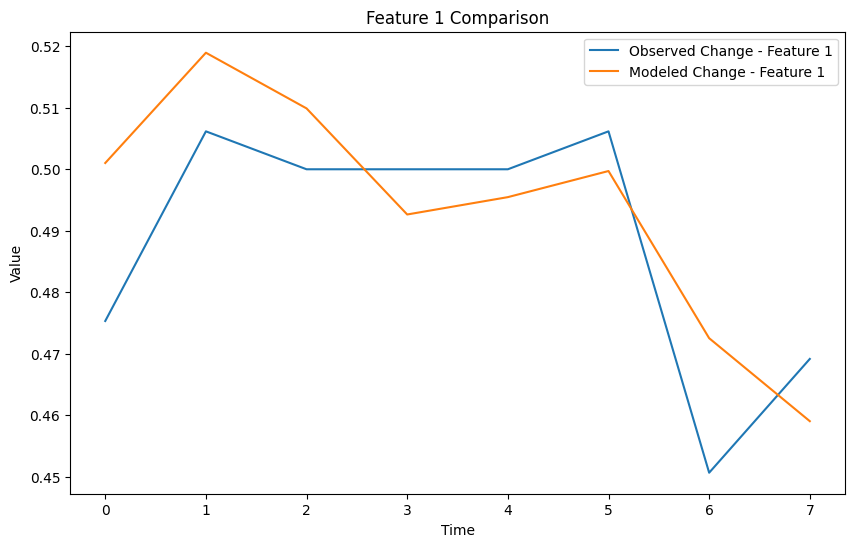

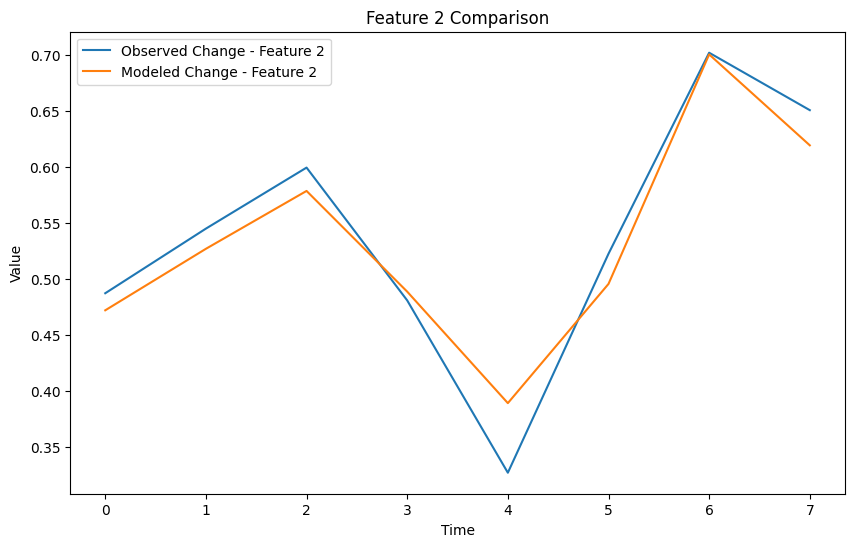

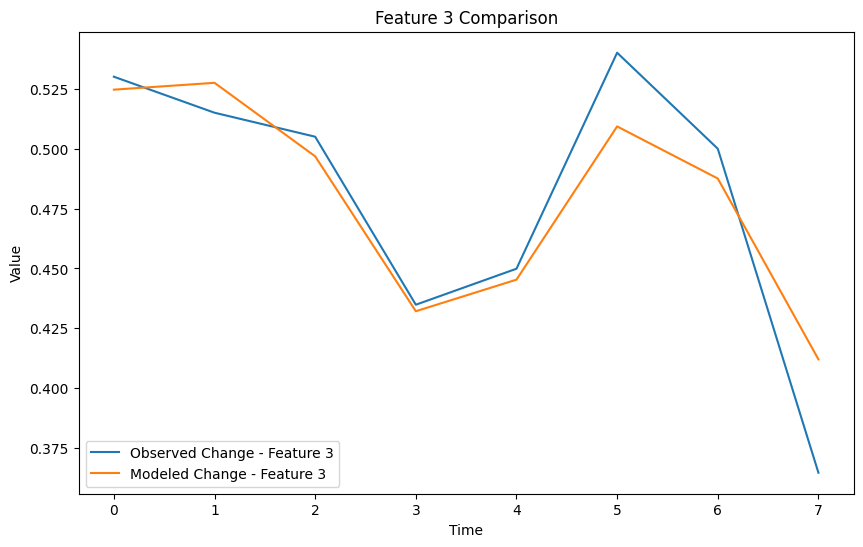

In [31]:
# Intialize Response Generator
generator = ResponseGenerator(cerberus_foresight, preparer.sliced_data, feature_indexes, preparer.max_change_dfs)

# Generate a response for a specific index
sel_index = 123
generator.generate_response(sel_index)

generator.plot_normalized_responses()

### Unscaled Response Review

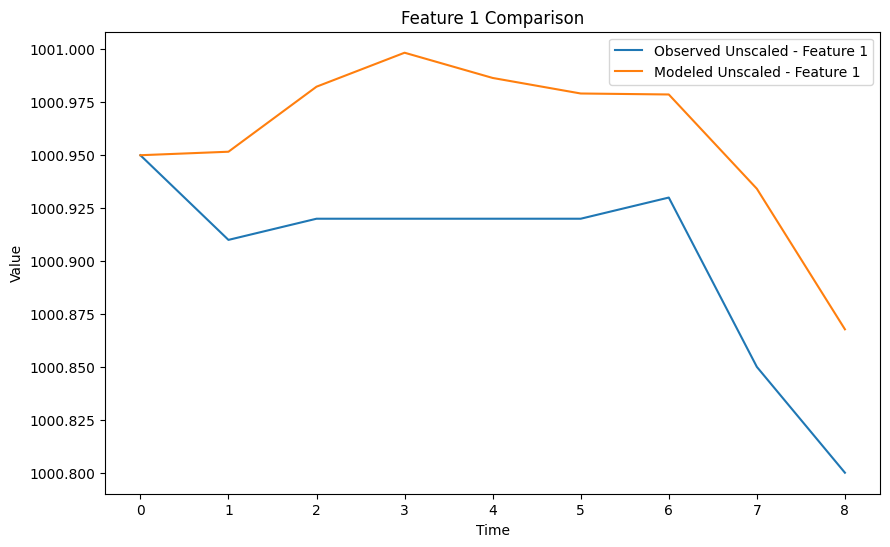

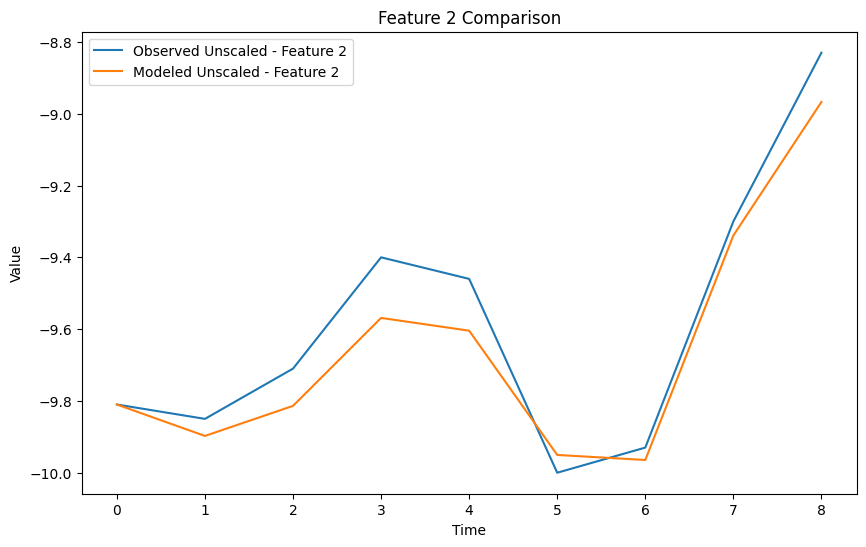

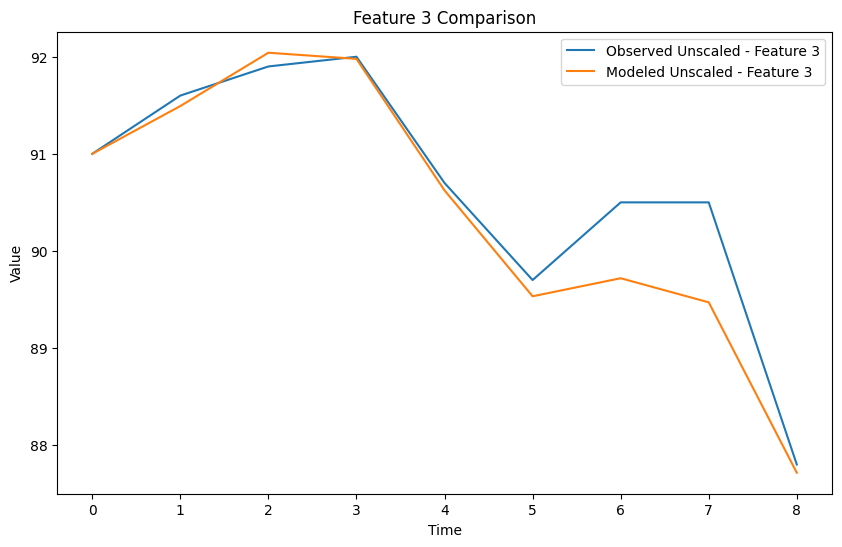

In [32]:
generator.plot_unscaled_responses(preparer.min_max_df, feature_indexes)